## Figure 3

In [1]:
import numpy as np
import json
import itertools

import igraph as ig

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

from scipy.linalg import eigh

from sklearn.linear_model import LinearRegression

### Subplots (a,b) -- Eigenspectra example

#### Load a pre-generated network instance

Download data from here:<br>
https://figshare.com/articles/dataset/Random_linear_physical_network_instances/24083532

Or generate your own networks using the `generate_randLPNs.ipynb` notebook.

In [2]:
N=300
alpha=1.
indep=1000
with open("saved_nets/randLPN_linklink_N%dalpha%.3findep%d.json"%(N,alpha,indep),'rt') as f:
        json_dict = json.load(f)
pts = np.array(json_dict['physnets'][0]['points'])
vws = np.array(json_dict['physnets'][0]['links'])


#### Include all physical edges

In [3]:
Afull = np.zeros((N,N))
for v,w in vws:
    Afull[v,w]=1
    Afull[w,v]=1

eigsfull,vecsfull = eigh(Afull)

In [4]:
sidxfull = sorted(list(range(N)),key=lambda x: -abs(eigsfull[x]))

In [5]:
vec2_full,vec3_full,vec4_full = vecsfull[:,sidxfull[1]],vecsfull[:,sidxfull[2]],vecsfull[:,sidxfull[3]]

Calculate semicircle pdf

In [6]:
R = 2*(2*len(vws)/300*(1-2*len(vws)/300/300))**.5
xsfull = np.linspace(-R,R,100)
semicirclefull = 2/np.pi/R**2*(R**2-xsfull**2)**.5

Generate reference ER

In [7]:
er = ig.Graph.Erdos_Renyi(n=N, m=len(vws))

In [8]:
er_A = np.zeros((N,N))
for e in er.es:
    v,w=e.tuple
    er_A[v,w]=1
    er_A[w,v]=1

er_eigs_full,er_vecs_full = eigh(er_A)

#### Include only the first 1000 physical links

In [9]:
A1000 = np.zeros((N,N))
for v,w in vws[:1000]:
    A1000[v,w]=1
    A1000[w,v]=1

eigs1000,vecs1000 = eigh(A1000)

In [10]:
sidx1000 = sorted(list(range(N)),key=lambda x: -(eigs1000[x]))

In [11]:
vec2_1000,vec3_1000,vec4_1000 = vecs1000[:,sidx1000[1]],vecs1000[:,sidx1000[2]],vecs1000[:,sidx1000[3]]


Calculate semicircle pdf

In [12]:
R = 2*(2*1000/300*(1-2*1000/300/300))**.5
xs1000 = np.linspace(-R,R,100)
semicircle1000 = 2/np.pi/R**2*(R**2-xs1000**2)**.5

Generate reference ER

In [13]:
er = ig.Graph.Erdos_Renyi(n=N, m=1000)

In [14]:
er_A = np.zeros((N,N))
for e in er.es:
    v,w=e.tuple
    er_A[v,w]=1
    er_A[w,v]=1

er_eigs_1000,er_vecs_1000 = eigh(er_A)

### Subplot (c) -- Predicted node position

Include all physical links

In [15]:
reg = LinearRegression().fit(np.array([vec2_full,vec3_full,vec4_full]).T, pts)
pred_coord_full = reg.predict(np.array([vec2_full,vec3_full,vec4_full]).T)

Using only the first 1000 links

In [16]:
reg = LinearRegression().fit(np.array([vec2_1000,vec3_1000,vec4_1000]).T, pts)
pred_coord_1000 = reg.predict(np.array([vec2_1000,vec3_1000,vec4_1000]).T)

### Subplot (d) -- $R^2$

#### Load pre-generated network instances and calculate statistics

Download data from here:<br>
https://figshare.com/articles/dataset/Random_linear_physical_network_instances/24083532

Or generate your own networks using the `generate_randLPNs.ipynb` notebook.

In [17]:
N=300

alphas=[2.,1.,.5,.35]
indep = 1000

#measurement points
mps = np.array(np.unique(np.round(np.logspace(0,np.log10(N*(N-1)/2),100))),dtype=int)

R2     = {}
R2std  = {}

## get Mmax for vertical dashed line
MMAX    = {}

for alpha in alphas:
    with open("saved_nets/randLPN_linklink_N%dalpha%.3findep%d.json"%(N,alpha,indep),'rt') as f:
        json_dict = json.load(f)
    
    r2s      = np.empty((indep,len(mps)))
    r2s[:,:] = np.nan
    
    Mmaxs = np.zeros(indep)
    
    #for i in range(indep): #uncomment to use 1000 samples, takes long to run
    for i in range(10):
        #read phys net
        d_pts = json_dict['physnets'][i]['points']
        d_vws = json_dict['physnets'][i]['links']
        d_pts = np.array(d_pts)
        d_vws = np.array(d_vws)
        
        #Mmax
        Mmaxs[i] = len(d_vws)
        
        #R2
        A = np.zeros((N,N))        
        prev_mp = 0
        for j,mp in enumerate(mps):
            if mp<=len(d_vws):
                for v,w in d_vws[prev_mp:mp]:
                    A[v,w]=1
                    A[w,v]=1
                
                eigs,vecs = eigh(A)#,subset_by_index=[N-5, N-1])
                
                sidx = sorted(list(range(len(eigs))),key=lambda x: -(eigs[x]))

                vec2,vec3,vec4 = vecs[:,sidx[1]],vecs[:,sidx[2]],vecs[:,sidx[3]]
                '''for vec in [vec2,vec3,vec4]:
                    vec -= min(vec)
                    vec /= max(vec)
                '''
                reg = LinearRegression().fit(np.array([vec2,vec3,vec4]).T, d_pts)
                r2s[i,j] = reg.score(np.array([vec2,vec3,vec4]).T, d_pts)
            prev_mp = mp
            
    R2[alpha]   =np.nanmean(r2s,axis=0)
    R2std[alpha]=np.nanstd(r2s,axis=0)
    
    MMAX[alpha]= Mmaxs
    


/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/posfaim/anaconda3/envs/physnet/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean 

### Final figure

''

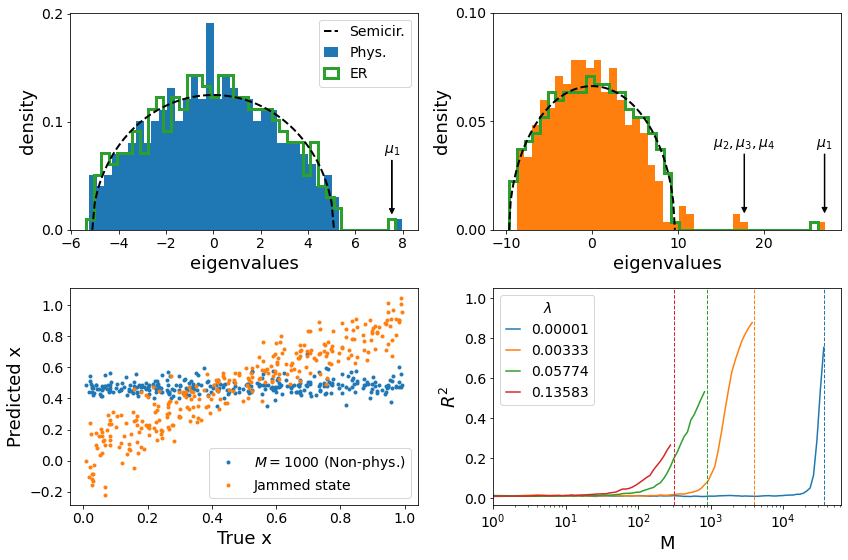

In [18]:
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(2,2,figsize=(12,8))
axs=axs.reshape(-1)

lw=1
lw2=1.5
ps = 4.5
lfs = 18
legfs = 14

plt.sca(axs[0])

plt.hist(eigs1000, bins=40,density=True,label='Phys.', color=colors[0])
plt.hist(er_eigs_1000, bins=40,density=True,histtype='step',label='ER',lw=3,color=colors[2])
plt.plot(xs1000,semicircle1000,'--',linewidth=2.,label='Semicir.',color='k')

axs[0].annotate(r'$\mu_1$', xy=(7.55, .015),  xycoords='data',
            xytext=(7.55, 0.08),
            arrowprops=dict(facecolor='black',headwidth=5.,headlength=5.,width=.5),
            horizontalalignment='center', verticalalignment='top')

plt.yticks([0,.1,.2])

plt.legend(handlelength=1., fontsize=legfs)
plt.xlabel('eigenvalues',fontsize=lfs)
plt.ylabel('density',fontsize=lfs)


plt.sca(axs[1])

plt.hist(eigsfull, bins=40,density=True,color=colors[1])
plt.hist(er_eigs_full, bins=40,density=True,histtype='step',label='ER',lw=3,color=colors[2])
plt.plot(xsfull,semicirclefull,'--k',linewidth=2.)
plt.xlabel('eigenvalues',fontsize=lfs)
plt.ylabel('density',fontsize=lfs)

axs[1].annotate(r'$\mu_1$', xy=(27, .015*.08/.15),  xycoords='data',
            xytext=(27, 0.08*.08/.15),
            arrowprops=dict(facecolor='black',headwidth=5.,headlength=5.,width=.5),
            horizontalalignment='center', verticalalignment='top')

axs[1].annotate(r'$\mu_2,\mu_3,\mu_4$', xy=(17.68, .015*.08/.15),  xycoords='data',
            xytext=(17.68, 0.08*.08/.15),
            arrowprops=dict(facecolor='black',headwidth=5.,headlength=5.,width=.5),
            horizontalalignment='center', verticalalignment='top')

plt.yticks([0,.05,.1])



plt.sca(axs[2])

plt.plot(pts[:,2],pred_coord_1000[:,2],'o', label = '$M=1000$ (Non-phys.)',markersize=3)
plt.plot(pts[:,2],pred_coord_full[:,2],'o', label = 'Jammed state',markersize=3)
plt.xlabel("True x",fontsize=lfs)
plt.ylabel("Predicted x",fontsize=lfs)
plt.legend(fontsize=legfs)


plt.sca(axs[3])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for alpha,color in zip([2.,1.,.5,.35],colors):
    plt.plot(mps[:len(R2[alpha])],R2[alpha],'-',color=color,label='%.5f'%N**-alpha)
    plt.axvline(np.max(MMAX[alpha]),color=color,ls='--',lw=1)
#cmap.to_rgba(alpha)
#plt.plot(np.max(MMAX[1]),R2[1][-1],'o',color=cmap.to_rgba(1.))
#plt.plot(mps[52],R2[1][52],'o',color=cmap.to_rgba(1.))


plt.ylim(top=1.05)
plt.xscale('log')

plt.xlim(left=1)
plt.legend(title=r'$\lambda$',handlelength=1.,loc='upper left')
plt.xlabel('M',fontsize=lfs)
plt.ylabel('$R^2$',fontsize=lfs);


plt.tight_layout()
#plt.savefig('fig-eigvec.pdf', transparent=True)

;